In [1]:
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector
from IPython.display import display
from qiskit.tools.visualization import plot_histogram

sim = Aer.get_backend("aer_simulator")

# Q12 前問にエラーがあった場合どのようになるか、Qiskitのエラーモデルを用いて確認せよ。

## 解答

Bitstring 101: Actual observation prob. = 0.01
Bitstring 010: Actual observation prob. = 0.01
Bitstring 110: Actual observation prob. = 0.02
Bitstring 100: Actual observation prob. = 0.01
Bitstring 001: Actual observation prob. = 0.02
Bitstring 111: Actual observation prob. = 0.46
Bitstring 000: Actual observation prob. = 0.46
Bitstring 011: Actual observation prob. = 0.01


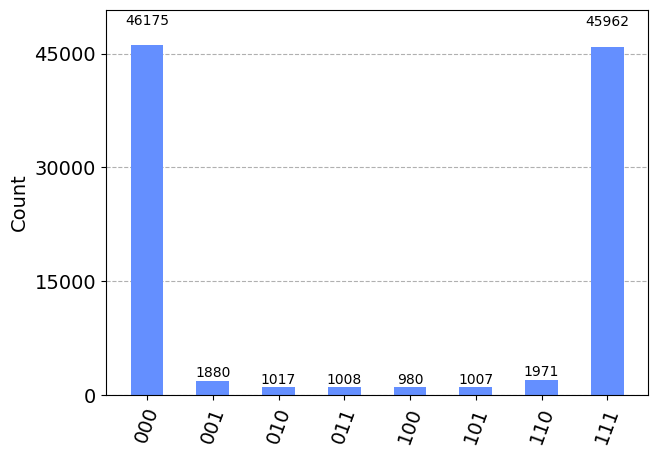

In [4]:
from qiskit_aer.noise import NoiseModel, pauli_error

qc = QuantumCircuit(3, 3)
qc.h(qubit=0)
qc.cx(control_qubit=0, target_qubit=1)
qc.cx(control_qubit=1, target_qubit=2)
qc.measure(qubit=[0, 1, 2], cbit=[0, 1, 2])


def create_noise_model(p_err: float) -> NoiseModel:
    """シミュレーション用のカスタムノイズモデルを返す関数"""
    noise_model = NoiseModel()
    # ビットフリップエラーを定義
    bit_flip_err_1_qubit = pauli_error(noise_ops=[('X', p_err), ('I', 1 - p_err)])
    bit_flip_err_2_qubit = bit_flip_err_1_qubit.tensor(other=bit_flip_err_1_qubit)
    # rzおよびsxゲートの実行時にビットフリップエラーが発生する
    noise_model.add_all_qubit_quantum_error(
        error=bit_flip_err_1_qubit,
        instructions=["rz", "sx"]
    )
    # cxゲートの実行時にビットフリップエラーが発生する
    noise_model.add_all_qubit_quantum_error(
        error=bit_flip_err_2_qubit,
        instructions=["cx"]
    )
    return noise_model

# エラー率が2%のノイズモデルを作成
noise_model = create_noise_model(p_err=0.02)
# 量子回路をネイティブゲートのみの回路に分解
qc_transpiled = transpile(circuits=qc, basis_gates=noise_model.basis_gates)

shots = 100000
counts = sim.run(circuits=qc_transpiled,
                 shots=shots,
                 noise_model=noise_model).result().get_counts()
for bitstring, count in counts.items():
    print(f"Bitstring {bitstring}: "
          f"Actual observation prob. = {np.round(count/shots, decimals=2)}")

plot_histogram(counts)

## 解説
量子ビットとして物理的な量子ビットを想定している限り、環境との相互作用等による量子ビットの汚染すなわち量子エラーは避けられない。Qiskitの`NoiseModel`を使うことで、量子エラーの発生をモデル化し、シミュレーションすることが出来る。量子エラーの発生箇所としては複数箇所検討することができる。ここでは、例としてゲート実行直後のビットフリップのみをモデル化している。具体的には、ネイティブゲートが実行される度に`p_err`の確率でXゲートを作用させる。結果としては、ビットフリップの発生により$|000\rangle$および$|111\rangle$以外の状態が測定される。

以下では簡単な1量子ビットの量子回路と`p_err=0.1`のノイズモデルを用いてノイズモデルの振る舞いをもう少し詳細に確認してみる。

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'rz', 'sx']
  All-qubits errors: ['rz', 'sx', 'cx']


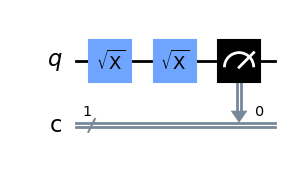

Bitstring 1: Actual observation prob. = 0.82
Bitstring 0: Actual observation prob. = 0.18


In [3]:
noise_model = create_noise_model(p_err=0.1)
print(noise_model)

qc = QuantumCircuit(1, 1)
qc.x(qubit=0)
qc.measure(qubit=0, cbit=0)

qc_transpiled = transpile(circuits=qc, basis_gates=noise_model.basis_gates)
display(qc_transpiled.draw(output="mpl"))

shots = 100000
counts = sim.run(circuits=qc_transpiled,
                 shots=shots,
                 noise_model=noise_model).result().get_counts()
for bitstring, count in counts.items():
    print(f"Bitstring {bitstring}: "
          f"Actual observation prob. = {np.round(count/shots, decimals=2)}")

測定の結果18%の確率でビットフリップが発生していることが分かる。ネイティブゲートであるSXゲートが実行される度に`p_err`の確率でXゲートが実行されるため、回路全体としてビットフリップが発生する確率は`2*p_err*(1-p_err)`から計算できる。`p_err=0.1`の場合にはこの確率は18%となり、測定の結果と一致する。

## 参考資料
- Qiskitチュートリアル https://qiskit.org/documentation/tutorials/simulators/3_building_noise_models.html